<a href="https://colab.research.google.com/github/Lisker2/CS309_Project/blob/main/Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data and library

In [ ]:
!git clone https://github.com/nadavbra/protein_bert
!git clone https://github.com/khanhlee/bert-enhancer
!git clone https://github.com/Lisker2/CS309_Project 
!pip install protein-bert
!pip install shap
import warnings
warnings.filterwarnings('ignore') 
import tensorflow as tf
import pandas as pd
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split
from proteinbert import OutputType, OutputSpec, FinetuningModelGenerator, load_pretrained_model, finetune, evaluate_by_len
from proteinbert.conv_and_global_attention_model import get_model_with_hidden_layers_as_outputs
from proteinbert import load_pretrained_model
import xgboost
from xgboost import XGBClassifier
import shap
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import math

# Useful functions

In [2]:
def performance(true_label, prediction):

  result = {}
  prediction_classes = []
  for i in prediction:
    try:
      if i[0] <= 0.5:
        prediction_classes.append(0)
      else:
        prediction_classes.append(1)
    except:
      if i <= 0.5:
        prediction_classes.append(0)
      else:
        prediction_classes.append(1)
  confusion_matrix_df = pd.DataFrame(confusion_matrix(true_label, prediction_classes, labels = [0,1]))
  TN = confusion_matrix_df[0][0]
  TP = confusion_matrix_df[1][1]
  FP = confusion_matrix_df[0][1]
  FN = confusion_matrix_df[1][0]
  result['Sensitivity'] = TP / (TP + FN)
  result['Specificity'] = TN / (TN + FP)
  result['AUC'] = (TP + TN) / (TP + FP + TN + FN)
  result['MCC'] = ((TP * TN) - (FP * FN)) / math.sqrt((FP + TP) * (TP + FN) * (TN + FP) * (TN + FN))
  
  return result

def history_visualize(model_history, fig_name):
  accuracy = model_history.history['accuracy']
  val_accuracy = model_history.history['val_accuracy']
  loss = model_history.history['loss']
  val_loss = model_history.history['val_loss']
  epoch = range(len(accuracy))

  plt.style.context('Solarize_Light2')
  plt.figure(figsize=(12,5))
  plt.title(fig_name)
  plt.subplot(2,2,1)
  plt.xlabel("epochs")
  plt.plot(epoch, accuracy, label='Train Accuracy')
  plt.plot(epoch, val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy')
  plt.legend()
  plt.subplot(2,2,2)
  plt.xlabel("epochs")
  plt.plot(epoch, loss, label='Train Loss')
  plt.plot(epoch, val_loss, label='Validation Loss')
  plt.title('Loss')
  plt.suptitle(fig_name)
  plt.legend()
  plt.savefig(fig_name + ".png")
  plt.show()

# Processing Data

In [14]:
# read the orginal data
non_cv = pd.read_csv('bert-enhancer/data/non.cv.txt')[::2]
non_cv.columns = ['seq']

label_1 = [0 for i in range(len(non_cv))]
non_cv['label'] = label_1

enhancer_cv = pd.read_csv('bert-enhancer/data/enhancer.cv.txt')[::2]
enhancer_cv.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_cv))]
enhancer_cv['label'] = label_1

non_ind = pd.read_csv('bert-enhancer/data/non.ind.txt')[::2]
non_ind.columns = ['seq']

label_1 = [0 for i in range(len(non_ind))]
non_ind['label'] = label_1

enhancer_ind = pd.read_csv('bert-enhancer/data/enhancer.ind.txt')[::2]
enhancer_ind.columns = ['seq']

label_1 = [1 for i in range(len(enhancer_ind))]
enhancer_ind['label'] = label_1

# concat data with label 1 and 0 seperately -- shuffled
enhancer_total = pd.concat([enhancer_cv, enhancer_ind],axis=0).sample(frac=1.0).reset_index(drop=True)
non_total = pd.concat([non_cv, non_ind ],axis=0).sample(frac=1.0).reset_index(drop=True)

# 1684 in total train = 1384 valid = 150 test = 150
train = pd.concat([enhancer_total[:1384], non_total[:1384]],axis=0).sample(frac=1.0).reset_index(drop=True)
valid = pd.concat([enhancer_total[1384:1534], non_total[1384:1534]],axis=0).sample(frac=1.0).reset_index(drop=True)
test = pd.concat([enhancer_total[1534:], non_total[1534:]],axis=0).sample(frac=1.0).reset_index(drop=True)

# max len
enhancer_sequence_length = train['seq'].map(lambda x: len(x)).max() + 2
print('sequence_length', enhancer_sequence_length)

# save data
train.to_csv("train.csv")
valid.to_csv("valid.csv")
test.to_csv("test.csv")

# download and load the pretrained model
pretrained_model_generator, input_encoder = load_pretrained_model("/content/")
enhancer_train_X = input_encoder.encode_X(train['seq'], enhancer_sequence_length)
enhancer_valid_X = input_encoder.encode_X(valid['seq'], enhancer_sequence_length)
enhancer_test_X = input_encoder.encode_X(test['seq'], enhancer_sequence_length)
enhancer_model_generator = get_model_with_hidden_layers_as_outputs(pretrained_model_generator.create_model(enhancer_sequence_length))


sequence_length 202


# Pre-trained

In [ ]:
# get the local_representation and global_representation from pretrained model
enhancer_local_representations_train, global_representations_train = enhancer_model_generator.predict(enhancer_train_X, batch_size = 64)
enhancer_local_representations_valid, global_representations_valid = enhancer_model_generator.predict(enhancer_valid_X, batch_size = 64)
enhancer_local_representations_test, global_representations_test = enhancer_model_generator.predict(enhancer_test_X, batch_size = 64)
print("enhancer_local_representations_train.shape",enhancer_local_representations_train.shape)

5/5 [==============================] - 0s 45ms/step
enhancer_local_representations_train.shape (2768, 202, 1562)


## PCA

### Reduce Dimension

In [ ]:
n_pca = 300

local_pretrained_pca = PCA(n_components = n_pca)
local_pretrained_pca.fit(enhancer_local_representations_train.reshape(2768,202*1562))
local_pretrained_pca.fit(enhancer_local_representations_test.reshape(300,202*1562))
local_pretrained_pca_train = local_pretrained_pca.transform(enhancer_local_representations_train.reshape(2768,202*1562))
local_pretrained_pca_test = local_pretrained_pca.transform(enhancer_local_representations_test.reshape(300,202*1562))

global_pretrained_pca = PCA(n_components = n_pca)
global_pretrained_pca.fit(global_representations_train)
global_pretrained_pca.fit(global_representations_test)
global_pretrained_pca_train = global_pretrained_pca.transform(global_representations_train)
global_pretrained_pca_test = global_pretrained_pca.transform(global_representations_test)

### Random Forest

In [ ]:
local_pretrained_RandomForest_PCA = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
local_pretrained_RandomForest_PCA.fit(local_pretrained_pca_train,train['label'])
local_prediction_pretrained_RandomForest_PCA = local_pretrained_RandomForest_PCA.predict(local_pretrained_pca_test)
performance_local_prediction_pretrained_RandomForest_PCA = performance(test['label'], local_prediction_pretrained_RandomForest_PCA)
print(performance_local_prediction_pretrained_RandomForest_PCA)

{'Sensitivity': 0.7302631578947368, 'Specificity': 0.7364864864864865, 'AUC': 0.7333333333333333, 'MCC': 0.46670815367983187}


In [ ]:
global_pretrained_RandomForest_PCA = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
global_pretrained_RandomForest_PCA.fit(global_pretrained_pca_train,train['label'])
global_prediction_pretrained_RandomForest_PCA = global_pretrained_RandomForest_PCA.predict(global_pretrained_pca_test)
performance_global_prediction_pretrained_RandomForest_PCA = performance(test['label'], global_prediction_pretrained_RandomForest_PCA)
print(performance_global_prediction_pretrained_RandomForest_PCA)

{'Sensitivity': 0.7410071942446043, 'Specificity': 0.7080745341614907, 'AUC': 0.7233333333333334, 'MCC': 0.4478725696981852}


### XGBoost

In [ ]:
local_pretrained_XGBClassifier_PCA = XGBClassifier()
local_pretrained_XGBClassifier_PCA.fit(local_pretrained_pca_train,train['label'])
local_prediction_pretrained_XGBClassifier_PCA = local_pretrained_XGBClassifier_PCA.predict(local_pretrained_pca_test)
performance_local_prediction_pretrained_XGBClassifier_PCA = performance(test['label'], local_prediction_pretrained_XGBClassifier_PCA)
print(performance_local_prediction_pretrained_XGBClassifier_PCA)

{'Sensitivity': 0.7412587412587412, 'Specificity': 0.7197452229299363, 'AUC': 0.73, 'MCC': 0.4605017084949758}


In [ ]:
global_pretrained_XGBClassifier_PCA = XGBClassifier()
global_pretrained_XGBClassifier_PCA.fit(global_pretrained_pca_train,train['label'])
global_prediction_pretrained_XGBClassifier_PCA = global_pretrained_XGBClassifier_PCA.predict(global_pretrained_pca_test)
performance_global_prediction_pretrained_XGBClassifier_PCA = performance(test['label'], global_prediction_pretrained_XGBClassifier_PCA)
print(performance_global_prediction_pretrained_XGBClassifier_PCA)

{'Sensitivity': 0.7361111111111112, 'Specificity': 0.717948717948718, 'AUC': 0.7266666666666667, 'MCC': 0.4536964357810802}


## Shap

### Feature Selection

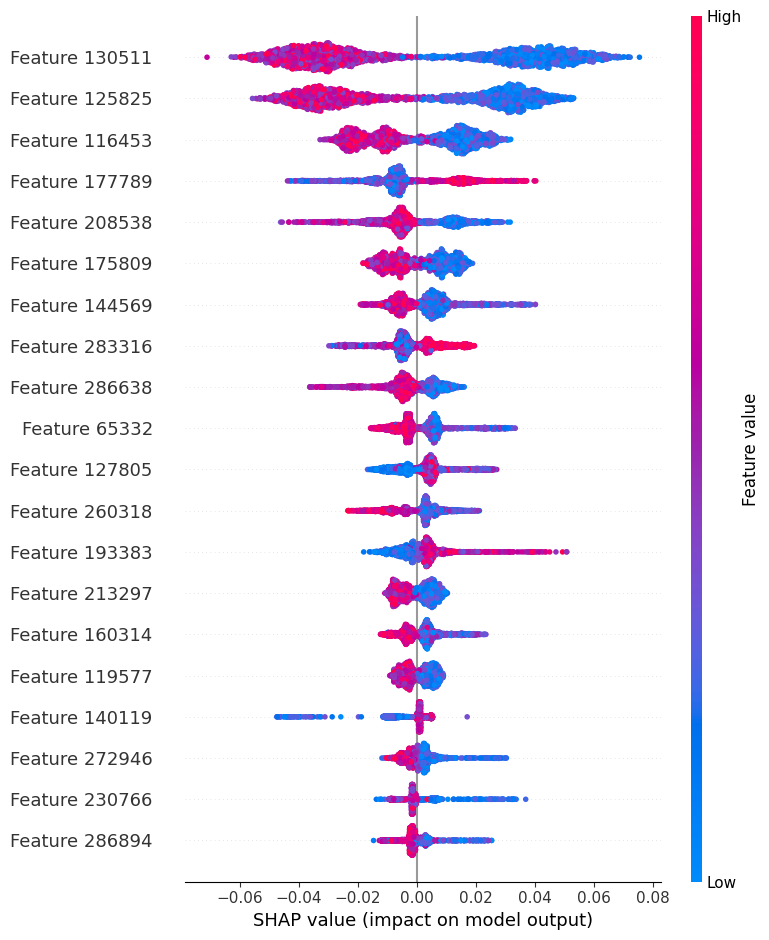

<Figure size 640x480 with 0 Axes>

In [ ]:
local_pretrained_shap = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(enhancer_local_representations_train.reshape(2768,202*1562), 
                                      label=train['label']), 100)
local_pretrained_shap_explainer = shap.TreeExplainer(local_pretrained_shap)
shap_values = local_pretrained_shap_explainer(enhancer_local_representations_train.reshape(2768,202*1562))
fig = plt.figure()
shap.summary_plot(shap_values, enhancer_local_representations_train.reshape(2768,202*1562))
plt.savefig("local_pretrained_shap_explainer.png")
plt.show()

In [ ]:
local_pretrained_shap_df = pd.DataFrame(shap_values.data[:,:700], columns = [i for i in range(700)])
vals = np.abs(shap_values.values).mean(0)
feature_names = [i for i in range(202*1562)]
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
local_pretrained_shap_train, local_pretrained_shap_valid, local_pretrained_shap_test = np.zeros((2768, 700)),  np.zeros((300, 700)),  np.zeros((300, 700))
for i in range(700):
  local_pretrained_shap_train[:, i] = enhancer_local_representations_train.reshape(2768,202*1562)[:, feature_importance['col_name'][i]]
  local_pretrained_shap_valid[:, i] = enhancer_local_representations_valid.reshape(300,202*1562)[:, feature_importance['col_name'][i]]
  local_pretrained_shap_test[:, i] = enhancer_local_representations_test.reshape(300,202*1562)[:, feature_importance['col_name'][i]]
feature_importance.head()

,col_name,feature_importance_vals
130511,130511,0.036332
125825,125825,0.030178
116453,116453,0.015647
177789,177789,0.011374
208538,208538,0.010162


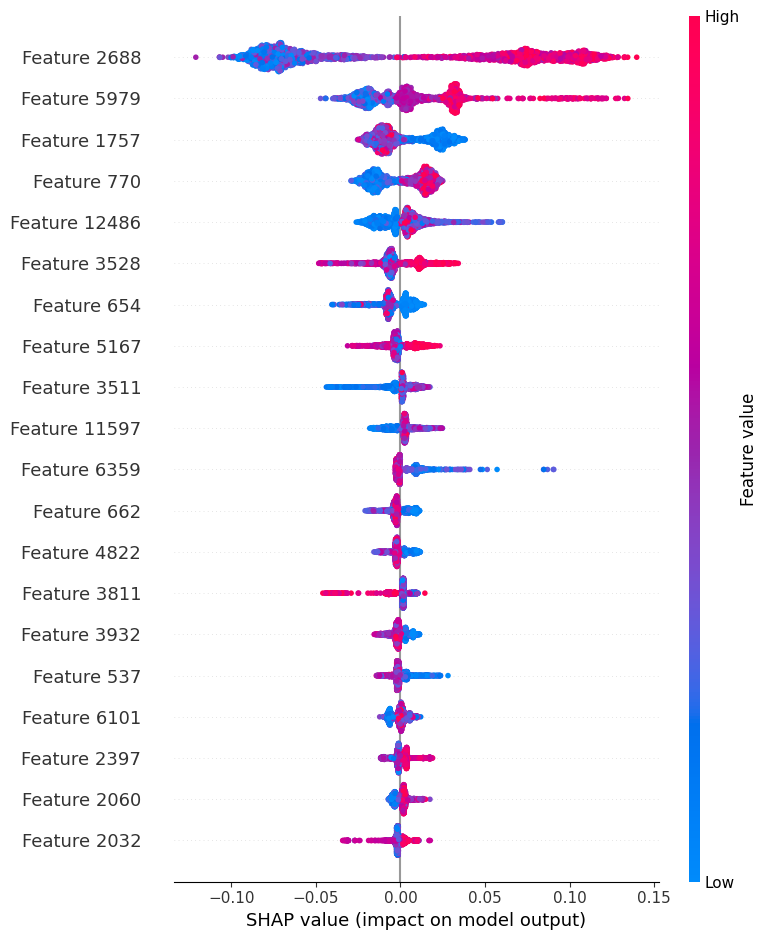

<Figure size 640x480 with 0 Axes>

In [ ]:
global_pretrained_shap = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(global_representations_train, 
                                      label=train['label']), 100)
global_pretrained_shap_explainer = shap.TreeExplainer(global_pretrained_shap)
shap_values = global_pretrained_shap_explainer(global_representations_train)
fig = plt.figure()
shap.summary_plot(shap_values, global_representations_train)
plt.savefig("global_pretrained_shap_explainer.png")
plt.show()

In [ ]:
global_pretrained_shap_df = pd.DataFrame(shap_values.data[:,:700], columns = [i for i in range(700)])
vals = np.abs(shap_values.values).mean(0)
feature_names = [i for i in range(global_representations_train.shape[1])]
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)
global_pretrained_shap_train, global_pretrained_shap_valid, global_pretrained_shap_test = np.zeros((2768, 700)),  np.zeros((300, 700)),  np.zeros((300, 700))
for i in range(700):
  global_pretrained_shap_train[:, i] = global_representations_train[:, feature_importance['col_name'][i]]
  global_pretrained_shap_valid[:, i] = global_representations_valid[:, feature_importance['col_name'][i]]
  global_pretrained_shap_test[:, i] = global_representations_test[:, feature_importance['col_name'][i]]
feature_importance.head()

,col_name,feature_importance_vals
2688,2688,0.072614
5979,5979,0.021344
1757,1757,0.014998
770,770,0.014431
12486,12486,0.010000


### Random Forest

In [ ]:
local_pretrained_RandomForest_shap = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
local_pretrained_RandomForest_shap.fit(local_pretrained_shap_train,train['label'])
local_prediction_pretrained_RandomForest_shap = local_pretrained_RandomForest_shap.predict(local_pretrained_shap_test)
performance_local_prediction_pretrained_RandomForest_shap = performance(test['label'], local_prediction_pretrained_RandomForest_shap)
print(performance_local_prediction_pretrained_RandomForest_shap)

{'Sensitivity': 0.753968253968254, 'Specificity': 0.6839080459770115, 'AUC': 0.7133333333333334, 'MCC': 0.43223514585232414}


In [ ]:
global_pretrained_RandomForest_shap = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
global_pretrained_RandomForest_shap.fit(global_pretrained_shap_train,train['label'])
global_prediction_pretrained_RandomForest_shap = global_pretrained_RandomForest_shap.predict(global_pretrained_shap_test)
performance_global_prediction_pretrained_RandomForest_shap = performance(test['label'], global_prediction_pretrained_RandomForest_shap)
print(performance_global_prediction_pretrained_RandomForest_shap)

{'Sensitivity': 0.7647058823529411, 'Specificity': 0.7195121951219512, 'AUC': 0.74, 'MCC': 0.4821044256050222}


### XGBoost

In [ ]:
local_pretrained_XGBClassifier_shap = XGBClassifier()
local_pretrained_XGBClassifier_shap.fit(local_pretrained_shap_train,train['label'])
local_prediction_pretrained_XGBClassifier_shap = local_pretrained_XGBClassifier_shap.predict(local_pretrained_shap_test)
performance_local_prediction_pretrained_XGBClassifier_shap = performance(test['label'], local_prediction_pretrained_XGBClassifier_shap)
print(performance_local_prediction_pretrained_XGBClassifier_shap)

{'Sensitivity': 0.7310344827586207, 'Specificity': 0.7161290322580646, 'AUC': 0.7233333333333334, 'MCC': 0.4469150217965969}


In [ ]:
global_pretrained_XGBClassifier_shap = XGBClassifier()
global_pretrained_XGBClassifier_shap.fit(global_pretrained_shap_train,train['label'])
global_prediction_pretrained_XGBClassifier_shap = global_pretrained_XGBClassifier_shap.predict(global_pretrained_shap_test)
performance_global_prediction_pretrained_XGBClassifier_shap = performance(test['label'], global_prediction_pretrained_XGBClassifier_shap)
print(performance_global_prediction_pretrained_XGBClassifier_shap)

{'Sensitivity': 0.7841726618705036, 'Specificity': 0.7453416149068323, 'AUC': 0.7633333333333333, 'MCC': 0.528088552330696}


## DNN

In [ ]:
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 2, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 5, restore_best_weights = True),
]

In [ ]:
local_pretrained_enhancer_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = enhancer_local_representations_train[0].shape),
    tf.keras.layers.Dense(3, activation='linear'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
local_pretrained_enhancer_DNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
local_pretrained_enhancer_DNN_history = local_pretrained_enhancer_DNN.fit(enhancer_local_representations_train, train['label'], 
                                               validation_data=(enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

10/10 [==============================] - 0s 10ms/step


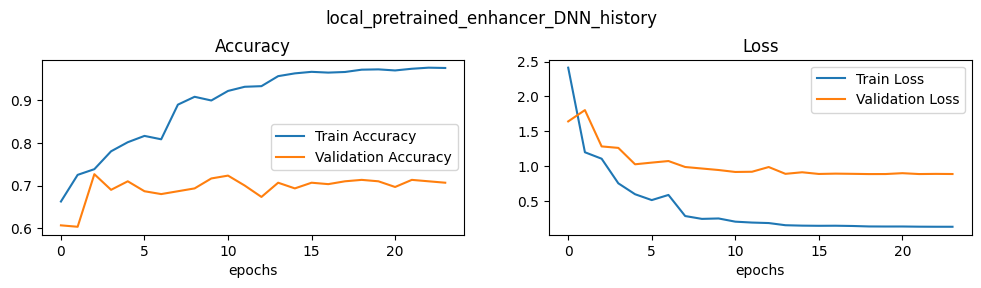

{'Sensitivity': 0.72, 'Specificity': 0.72, 'AUC': 0.72, 'MCC': 0.44}


In [ ]:
local_pretrained_enhancer_DNN_predict_Y = local_pretrained_enhancer_DNN.predict(enhancer_local_representations_test)
history_visualize(local_pretrained_enhancer_DNN_history, "local_pretrained_enhancer_DNN_history")
performance_local_pretrained_enhancer_DNN = performance(test['label'], local_pretrained_enhancer_DNN_predict_Y )
print(performance_local_pretrained_enhancer_DNN)

In [ ]:
global_pretrained_enhancer_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, activation='linear'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
global_pretrained_enhancer_DNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
global_pretrained_enhancer_DNN_history = global_pretrained_enhancer_DNN.fit(global_representations_train, train['label'], 
                                               validation_data=(global_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

10/10 [==============================] - 0s 3ms/step


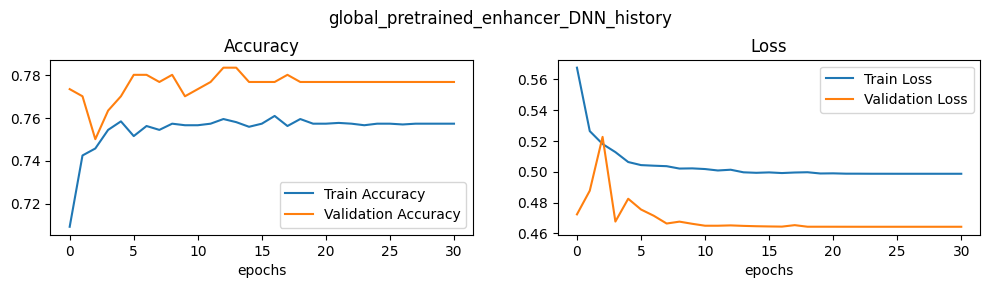

{'Sensitivity': 0.7536231884057971, 'Specificity': 0.7160493827160493, 'AUC': 0.7333333333333333, 'MCC': 0.468167206444658}


In [ ]:
global_pretrained_enhancer_DNN_predict_Y = global_pretrained_enhancer_DNN.predict(global_representations_test)
history_visualize(global_pretrained_enhancer_DNN_history, "global_pretrained_enhancer_DNN_history")
performance_global_pretrained_enhancer_DNN = performance(test['label'], global_pretrained_enhancer_DNN_predict_Y )
print(performance_global_pretrained_enhancer_DNN)

## CNN

In [ ]:
local_pretrained_enhancer_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(202, 1562, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
local_pretrained_enhancer_CNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
local_pretrained_enhancer_CNN_history = local_pretrained_enhancer_CNN.fit(enhancer_local_representations_train, train['label'], 
                                               validation_data=(enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

10/10 [==============================] - 0s 20ms/step


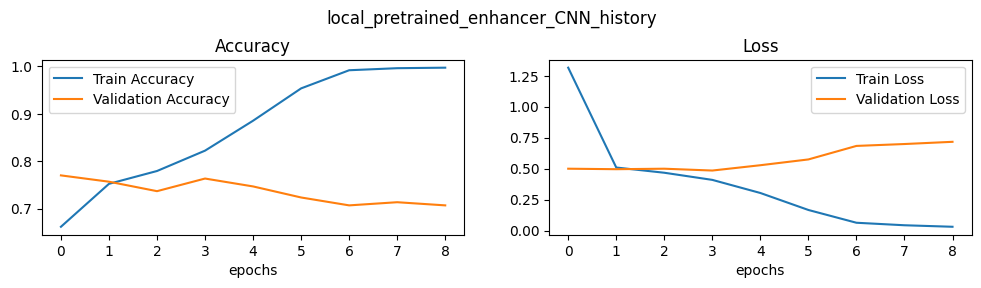

{'Sensitivity': 0.7575757575757576, 'Specificity': 0.7023809523809523, 'AUC': 0.7266666666666667, 'MCC': 0.4566330129477155}


In [ ]:
local_pretrained_enhancer_CNN_predict_Y = local_pretrained_enhancer_CNN.predict(enhancer_local_representations_test)
history_visualize(local_pretrained_enhancer_CNN_history, "local_pretrained_enhancer_CNN_history")
performance_local_pretrained_enhancer_CNN = performance(test['label'], local_pretrained_enhancer_CNN_predict_Y )
print(performance_local_pretrained_enhancer_CNN)

In [ ]:
global_pretrained_enhancer_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(15599, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
global_pretrained_enhancer_CNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
global_pretrained_enhancer_CNN_history = global_pretrained_enhancer_CNN.fit(global_representations_train.reshape(2768, 15599, 1), train['label'], 
                                               validation_data=(global_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

10/10 [==============================] - 0s 3ms/step


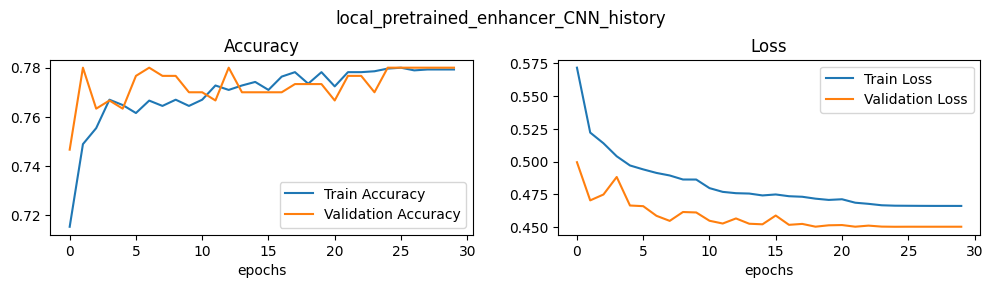

{'Sensitivity': 0.7638888888888888, 'Specificity': 0.7435897435897436, 'AUC': 0.7533333333333333, 'MCC': 0.5070724870494426}


In [ ]:
global_pretrained_enhancer_CNN_predict_Y = global_pretrained_enhancer_CNN.predict(global_representations_test)
history_visualize(global_pretrained_enhancer_CNN_history, "global_pretrained_enhancer_CNN_history")
performance_global_pretrained_enhancer_CNN = performance(test['label'], global_pretrained_enhancer_CNN_predict_Y )
print(performance_global_pretrained_enhancer_CNN)

# Fine-Tuned

## Fine-Tuned the model

ProteinBert is implemented in Python 3.6 and Tensorflow 2.4.0. The pre-trained implementation directly use the default library verion in Colab. However, the fine-tuned part has version conflict issues.
- We install Python 3.6 and Tensorflow 2.4.0 in Colab.
- We also fine-tuned the model on our own computer.
It takes a long time --> instead of re-running it, you can jump to !wget zip ceil.


### Method 1

In [ ]:
# first install python 3.6
!sudo apt-get update -y
!sudo apt-get install python3.6
# change alternatives
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.6 1
# select python version
!sudo update-alternatives --config python3
# check python version
!python --version
# install pip for new python 
!sudo apt-get install python3.6-distutils
!wget https://bootstrap.pypa.io/get-pip.py
!python get-pip.py
# upgrade pip
!sudo apt install python3-pip
!python -m pip install --upgrade pip

# this can download all the library we need
!python3.6 -m pip install tensorflow==2.4.0
!python3.6 -m pip install protein-bert
!python3.6 -m pip install matplotlib
!python3.6 -m pip  install scikit-learn
!python3.6 -m pip  install numpy
!python3.6 -m pip  install pandas
!python3.6 -m pip  install scipy
!python3.6 -m pip  install ipykernel

In [ ]:
# this can tune the model in colab
!python3.6 /content/CS309_Project/code_py/tune.py

sequence_length 202
[2023_05_06-10:28:44] Training set: Filtered out 0 of 2768 (0.0%) records of lengths exceeding 200.
[2023_05_06-10:28:44] Validation set: Filtered out 0 of 300 (0.0%) records of lengths exceeding 200.
[2023_05_06-10:28:44] Training the entire fine-tuned model...
2023-05-06 10:28:45.062291: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcusolver.so.10'; dlerror: libcusolver.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib/python3.10/dist-packages/cv2/../../lib64:/usr/lib64-nvidia
2023-05-06 10:28:45.066455: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1757] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
E

### Method 2
The following two code blocks are copied from out local computers (not runable), showing the process of tuning process.

In [ ]:
results, confusion_matrix = evaluate_by_len(model_generator, input_encoder, OUTPUT_SPEC, test['seq'], test['label'],
        start_seq_len = enhancer_sequence_length, start_batch_size = 32)

print('Test-set performance:')
display(results)

print('Confusion matrix:')
display(confusion_matrix)

Test-set performance:


,# records,AUC
Model seq len,,
202,300,0.854089
All,300,0.854089


Confusion matrix:


,0,1
0,129,21
1,38,112


GTCCTCTCCTCTCCTCTCCCCTTCTCTTCTTTCTTTTTGAGTCAGGGTCTCGCTCTGTCACCCTGGCTGGAGTCCAGTGGCCTGATCATGTCTTACGTCGAACCCTGGTTGATCATGATCTTCTAAGAATGGTCTTATTCAACTTTCTTTCCATTTTCCCCATTCCTCAAGCACACTAAGAAAAGGCTGTATTACATGGA 0


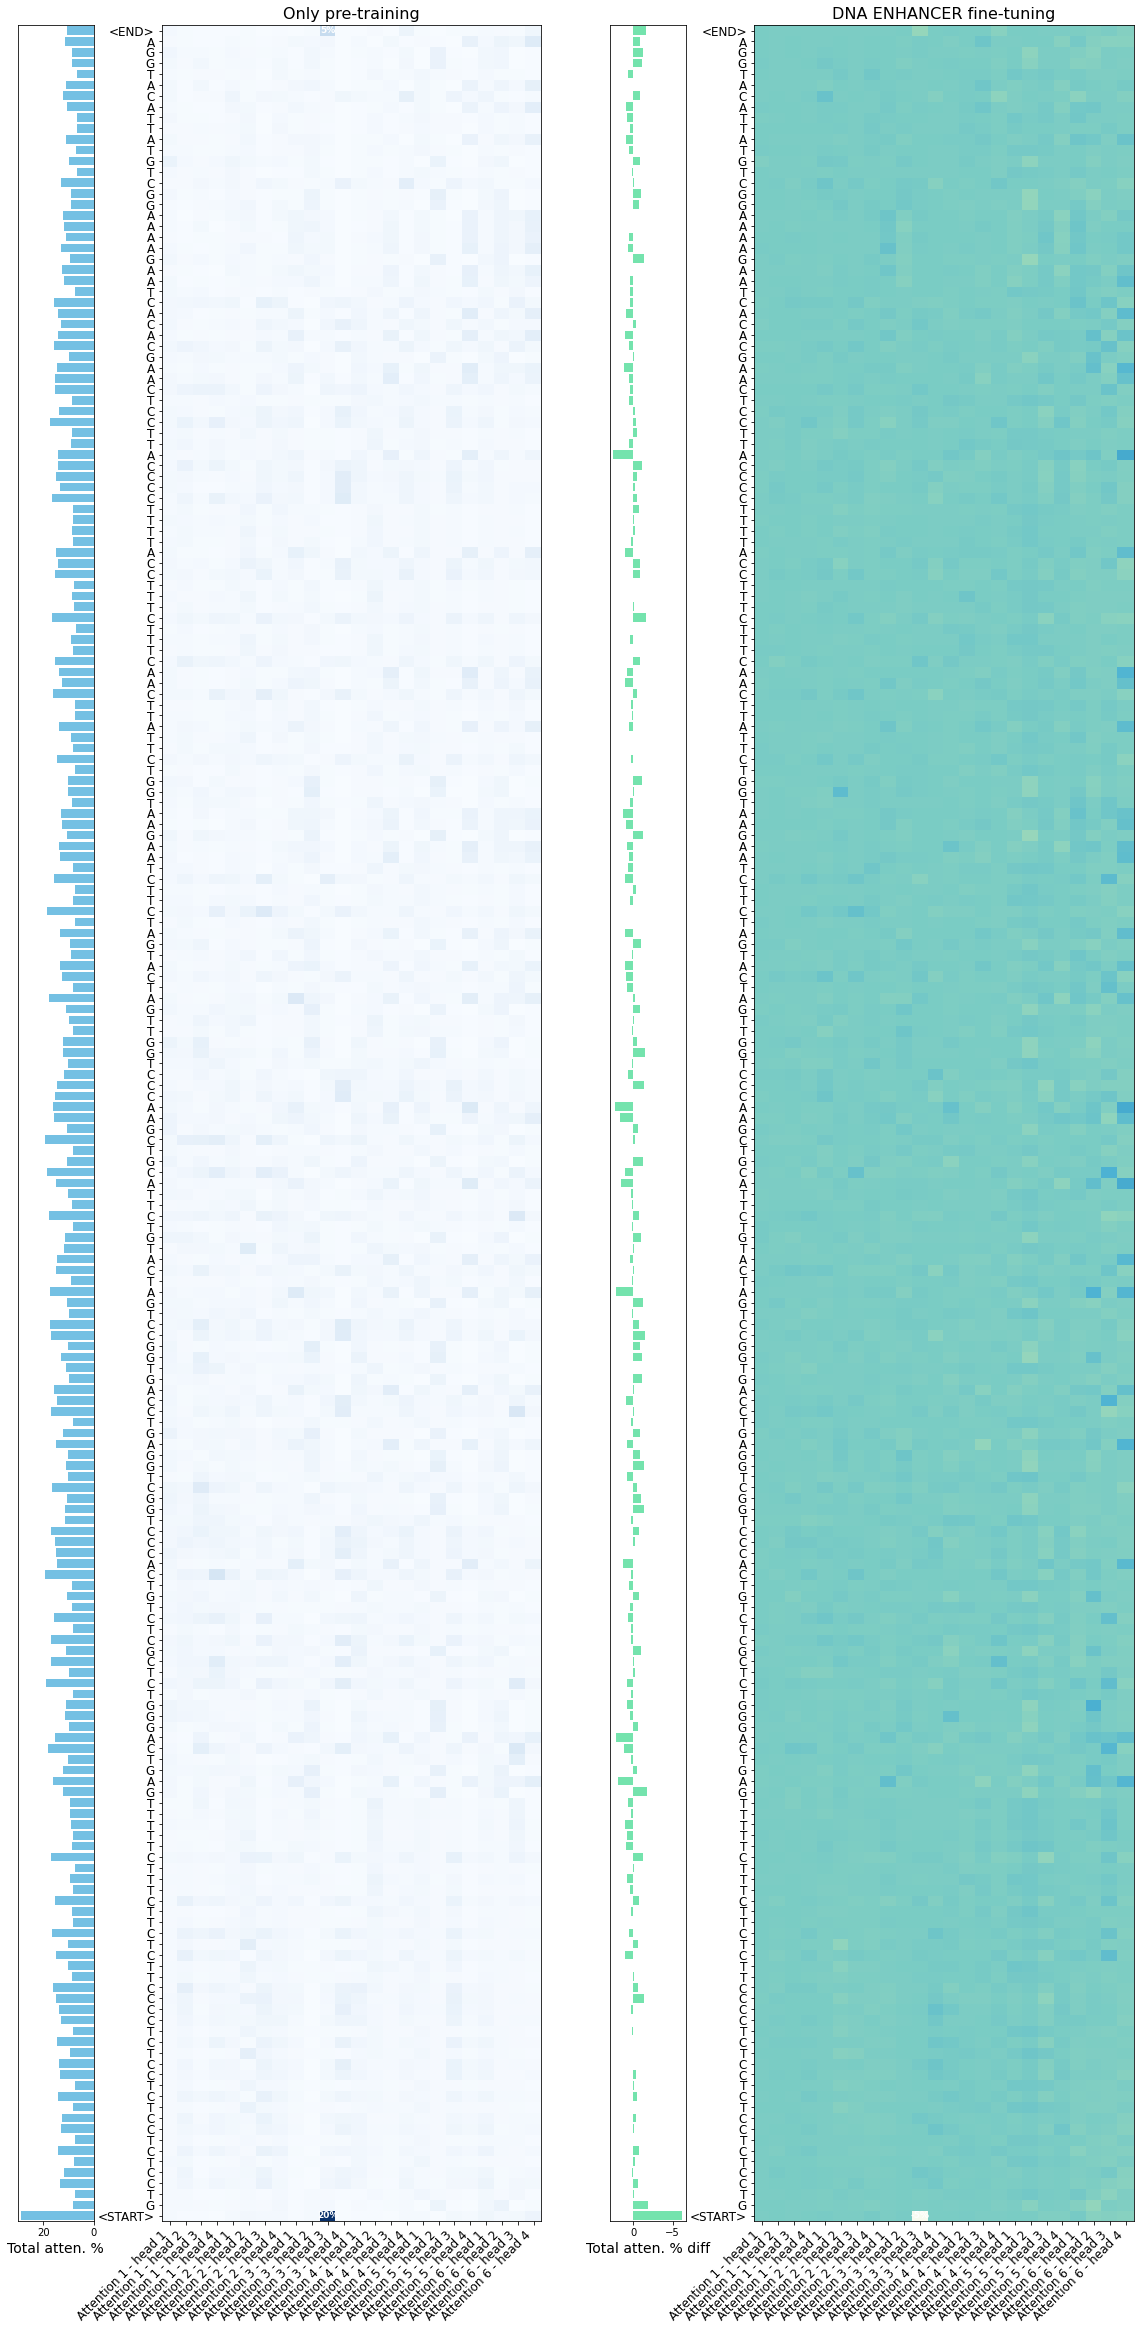

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def calculate_attentions(model, input_encoder, seq, seq_len = None):
    
    from tensorflow.keras import backend as K
    from proteinbert.tokenization import index_to_token
    
    if seq_len is None:
        seq_len = len(seq) + 2
    
    X = input_encoder.encode_X([seq], seq_len)
    (X_seq,), _ = X
    seq_tokens = list(map(index_to_token.get, X_seq))

    model_inputs = [layer.input for layer in model.layers if 'InputLayer' in str(type(layer))][::-1]
    model_attentions = [layer.calculate_attention(layer.input) for layer in model.layers if 'GlobalAttention' in str(type(layer))]
    invoke_model_attentions = K.function(model_inputs, model_attentions)
    attention_values = invoke_model_attentions(X)
    
    attention_labels = []
    merged_attention_values = []

    for attention_layer_index, attention_layer_values in enumerate(attention_values):
        for head_index, head_values in enumerate(attention_layer_values):
            attention_labels.append('Attention %d - head %d' % (attention_layer_index + 1, head_index + 1))
            merged_attention_values.append(head_values)

    attention_values = np.array(merged_attention_values)
    
    return attention_values, seq_tokens, attention_labels

def plot_attention(attention_values, seq_tokens, attention_labels, ax, cmap = 'Reds', vmin = 0, vmax = None, text_value_threshold = 0.1):

    heatmap = ax.pcolor(attention_values.transpose(), cmap = cmap, vmin = vmin, vmax = vmax)

    ax.set_xticks(np.arange(len(attention_labels)) + 0.5)
    ax.set_xticklabels(attention_labels, rotation = 45, ha = 'right', fontsize = 12)
    ax.set_yticks(np.arange(len(seq_tokens)) + 0.5)
    ax.set_yticklabels(seq_tokens, fontsize = 12)

    for i, row in enumerate(attention_values):
        for j, value in enumerate(row):
            if abs(value) >= text_value_threshold:
                add_plus_sign = attention_values.min() < 0 and value > 0
                plus_sign = '+' if add_plus_sign else ''
                ax.text(i + 0.5, j + 0.5, plus_sign + '%d%%' % (100 * value), color = 'white', ha = 'center', va = 'center', \
                        fontsize = 9, fontweight = 'bold', fontstretch = 'condensed')
                
chosen_index = ((test['seq'].str.len()).abs()).sort_values().index[0]
seq = test.loc[chosen_index, 'seq']
label = test.loc[chosen_index, 'label']
                
seq_len = enhancer_sequence_length 

model = pretrained_model_generator.create_model(seq_len)
pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)

model = model_generator.create_model(seq_len)
finetuned_attention_values, finetuned_seq_tokens, finetuned_attention_labels = calculate_attentions(model, input_encoder, seq, \
        seq_len = seq_len)
assert finetuned_seq_tokens == pretrained_seq_tokens
assert finetuned_attention_labels == pretrained_attention_labels[:len(finetuned_attention_labels)]

fig, axes = plt.subplots(ncols = 4, figsize = (20, 0.2 * seq_len), gridspec_kw = dict(width_ratios = [1, 5, 1, 5]))
fig.subplots_adjust(wspace = 0.3)

axes[0].barh(np.arange(seq_len), 100 * pretrained_attention_values.sum(axis = 0), color = '#74c0e3')
axes[0].set_ylim((-0.5, seq_len - 0.5))
axes[0].set_yticks([])
axes[0].invert_xaxis()
axes[0].set_xlabel('Total atten. %', fontsize = 14)

vmax = pretrained_attention_values.max()
plot_attention(pretrained_attention_values, pretrained_seq_tokens, pretrained_attention_labels, axes[1], cmap = 'Blues', vmax = vmax, \
        text_value_threshold = 0.05)
axes[1].set_title('Only pre-training', fontsize = 16)

axes[2].barh(np.arange(seq_len), 100 * (finetuned_attention_values - pretrained_attention_values).sum(axis = 0), color = '#74e3ad')
axes[2].set_ylim((-0.5, seq_len - 0.5))
axes[2].set_yticks([])
axes[2].invert_xaxis()
axes[2].set_xlabel('Total atten. % diff', fontsize = 14)

attention_diff = finetuned_attention_values - pretrained_attention_values[:len(finetuned_attention_labels), :]
vmax = np.abs(attention_diff).max()
plot_attention(attention_diff, finetuned_seq_tokens, finetuned_attention_labels, axes[3], cmap = 'GnBu', vmin = -vmax, vmax = vmax, \
        text_value_threshold = 0.03)
axes[3].set_title('%s fine-tuning' % "DNA ENHANCER", fontsize = 16)

print(seq, label)

### Direct load

In [5]:
!wget http://43.143.180.76/fine_tuned_model.zip
!unzip fine_tuned_model.zip

--2023-05-06 14:11:03--  http://43.143.180.76/fine_tuned_model.zip
Connecting to 43.143.180.76:80... connected.
HTTP request sent, awaiting response... 200 
Length: 59647786 (57M) [application/zip]
Saving to: ‘fine_tuned_model.zip’

fine_tuned_model.zi 100%[===================>]  56.88M   509KB/s    in 2m 4s   

2023-05-06 14:13:08 (468 KB/s) - ‘fine_tuned_model.zip’ saved [59647786/59647786]

Archive:  fine_tuned_model.zip
   creating: fine_tuned_model/
  inflating: fine_tuned_model/.DS_Store  
  inflating: __MACOSX/fine_tuned_model/._.DS_Store  
   creating: fine_tuned_model/variables/
  inflating: fine_tuned_model/saved_model.pb  
  inflating: __MACOSX/fine_tuned_model/._saved_model.pb  
   creating: fine_tuned_model/assets/
  inflating: fine_tuned_model/variables/.DS_Store  
  inflating: __MACOSX/fine_tuned_model/variables/._.DS_Store  
  inflating: fine_tuned_model/variables/variables.data-00000-of-00001  
  inflating: __MACOSX/fine_tuned_model/variables/._variables.data-00000-of-

In [19]:
fine_tuned_model = tf.keras.models.load_model('fine_tuned_model')
# get the local_representation and global_representation from pretrained model
tuned_enhancer_local_representations_train, tuned_global_representations_train = fine_tuned_model.predict(enhancer_train_X, batch_size = 64)
tuned_enhancer_local_representations_valid, tuned_global_representations_valid = fine_tuned_model.predict(enhancer_valid_X, batch_size = 64)
tuned_enhancer_local_representations_test, tuned_global_representations_test = fine_tuned_model.predict(enhancer_test_X, batch_size = 64)
print("tuned_eenhancer_local_representations_train.shape",tuned_enhancer_local_representations_train.shape)

5/5 [==============================] - 1s 218ms/step
tuned_eenhancer_local_representations_train.shape (2768, 202, 1536)


## PCA

### Reduce Dimension

In [8]:
n_pca = 300

tuned_local_pretrained_pca = PCA(n_components = n_pca)
tuned_local_pretrained_pca.fit(tuned_enhancer_local_representations_train.reshape(2768,202*1536))
tuned_local_pretrained_pca.fit(tuned_enhancer_local_representations_test.reshape(300,202*1536))
tuned_local_pretrained_pca_train = tuned_local_pretrained_pca.transform(tuned_enhancer_local_representations_train.reshape(2768,202*1536))
tuned_local_pretrained_pca_test = tuned_local_pretrained_pca.transform(tuned_enhancer_local_representations_test.reshape(300,202*1536))

tuned_global_pretrained_pca = PCA(n_components = n_pca)
tuned_global_pretrained_pca.fit(tuned_global_representations_train)
tuned_global_pretrained_pca.fit(tuned_global_representations_test)
tuned_global_pretrained_pca_train = tuned_global_pretrained_pca.transform(tuned_global_representations_train)
tuned_global_pretrained_pca_test = tuned_global_pretrained_pca.transform(tuned_global_representations_test)

### Random Forest

In [14]:
tuned_local_pretrained_RandomForest_PCA = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
tuned_local_pretrained_RandomForest_PCA.fit(tuned_local_pretrained_pca_train,train['label'])
tuned_local_prediction_pretrained_RandomForest_PCA = tuned_local_pretrained_RandomForest_PCA.predict(tuned_local_pretrained_pca_test)
tuned_performance_local_prediction_pretrained_RandomForest_PCA = performance(test['label'], tuned_local_prediction_pretrained_RandomForest_PCA)
print(tuned_performance_local_prediction_pretrained_RandomForest_PCA)

{'Sensitivity': 0.8, 'Specificity': 0.7806451612903226, 'AUC': 0.79, 'MCC': 0.580322490989611}


In [15]:
tuned_global_pretrained_RandomForest_PCA = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
tuned_global_pretrained_RandomForest_PCA.fit(tuned_global_pretrained_pca_train,train['label'])
tuned_global_prediction_pretrained_RandomForest_PCA = tuned_global_pretrained_RandomForest_PCA.predict(tuned_global_pretrained_pca_test)
tuned_performance_global_prediction_pretrained_RandomForest_PCA = performance(test['label'], tuned_global_prediction_pretrained_RandomForest_PCA)
print(tuned_performance_global_prediction_pretrained_RandomForest_PCA)

{'Sensitivity': 0.8091603053435115, 'Specificity': 0.7396449704142012, 'AUC': 0.77, 'MCC': 0.5443848353041852}


### XGBoost

In [16]:
tuned_local_pretrained_XGBClassifier_PCA = XGBClassifier()
tuned_local_pretrained_XGBClassifier_PCA.fit(tuned_local_pretrained_pca_train,train['label'])
tuned_local_prediction_pretrained_XGBClassifier_PCA = tuned_local_pretrained_XGBClassifier_PCA.predict(tuned_local_pretrained_pca_test)
tuned_performance_local_prediction_pretrained_XGBClassifier_PCA = performance(test['label'], tuned_local_prediction_pretrained_XGBClassifier_PCA)
print(tuned_performance_local_prediction_pretrained_XGBClassifier_PCA)

{'Sensitivity': 0.782312925170068, 'Specificity': 0.7712418300653595, 'AUC': 0.7766666666666666, 'MCC': 0.5534440332110705}


In [17]:
tuned_global_pretrained_XGBClassifier_PCA = XGBClassifier()
tuned_global_pretrained_XGBClassifier_PCA.fit(tuned_global_pretrained_pca_train,train['label'])
tuned_global_prediction_pretrained_XGBClassifier_PCA = tuned_global_pretrained_XGBClassifier_PCA.predict(tuned_global_pretrained_pca_test)
tuned_performance_global_prediction_pretrained_XGBClassifier_PCA = performance(test['label'], tuned_global_prediction_pretrained_XGBClassifier_PCA)
print(tuned_performance_global_prediction_pretrained_XGBClassifier_PCA)

{'Sensitivity': 0.7986111111111112, 'Specificity': 0.7756410256410257, 'AUC': 0.7866666666666666, 'MCC': 0.5737925511348956}


## Shap

### Feature Selection

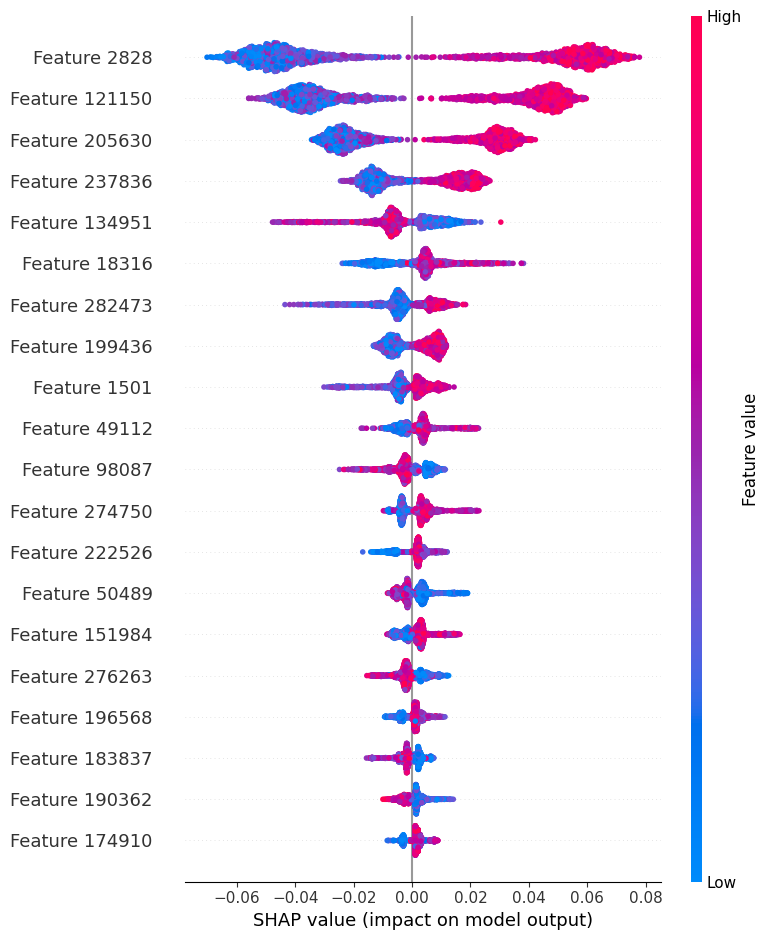

<Figure size 640x480 with 0 Axes>

In [10]:
tuned_local_pretrained_shap = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(tuned_enhancer_local_representations_train.reshape(2768,202*1536), 
                                      label=train['label']), 100)
tuned_local_pretrained_shap_explainer = shap.TreeExplainer(tuned_local_pretrained_shap)
tuned_shap_values = tuned_local_pretrained_shap_explainer(tuned_enhancer_local_representations_train.reshape(2768,202*1536))
fig = plt.figure()
shap.summary_plot(tuned_shap_values, tuned_enhancer_local_representations_train.reshape(2768,202*1536))
plt.savefig("tuned_local_pretrained_shap_explainer.png")
plt.show()

In [11]:
tuned_local_pretrained_shap_df = pd.DataFrame(tuned_shap_values.data[:,:700], columns = [i for i in range(700)])
tuned_vals = np.abs(tuned_shap_values.values).mean(0)
tuned_feature_names = [i for i in range(202*1536)]
tuned_feature_importance = pd.DataFrame(list(zip(tuned_feature_names, tuned_vals)),
                                  columns=['col_name','tuned_feature_importance_vals'])
tuned_feature_importance.sort_values(by=['tuned_feature_importance_vals'],
                               ascending=False, inplace=True)
tuned_local_pretrained_shap_train, tuned_local_pretrained_shap_valid, tuned_local_pretrained_shap_test = np.zeros((2768, 700)),  np.zeros((300, 700)),  np.zeros((300, 700))
for i in range(700):
  tuned_local_pretrained_shap_train[:, i] = tuned_enhancer_local_representations_train.reshape(2768,202*1536)[:, tuned_feature_importance['col_name'][i]]
  tuned_local_pretrained_shap_valid[:, i] = tuned_enhancer_local_representations_valid.reshape(300,202*1536)[:, tuned_feature_importance['col_name'][i]]
  tuned_local_pretrained_shap_test[:, i] = tuned_enhancer_local_representations_test.reshape(300,202*1536)[:, tuned_feature_importance['col_name'][i]]
tuned_feature_importance.head()

,col_name,tuned_feature_importance_vals
2828,2828,0.048658
121150,121150,0.038008
205630,205630,0.025319
237836,237836,0.014572
134951,134951,0.009169


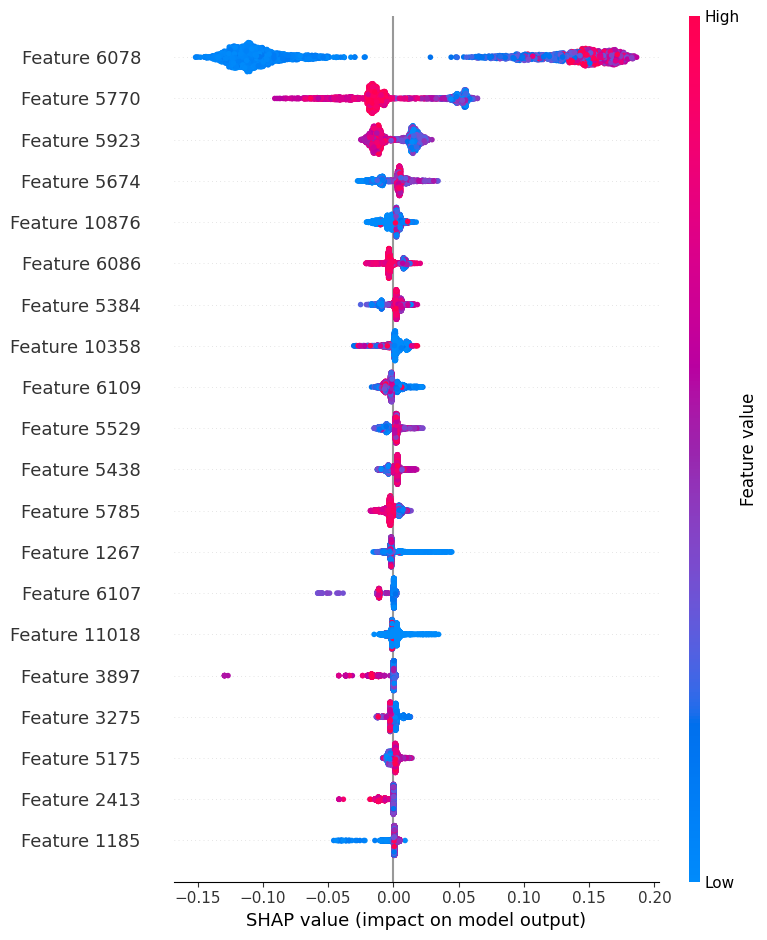

<Figure size 640x480 with 0 Axes>

In [18]:
tuned_global_pretrained_shap = xgboost.train({"learning_rate": 0.01}, 
                      xgboost.DMatrix(tuned_global_representations_train, 
                                      label=train['label']), 100)
tuned_global_pretrained_shap_explainer = shap.TreeExplainer(tuned_global_pretrained_shap)
tuned_shap_values = tuned_global_pretrained_shap_explainer(tuned_global_representations_train)
fig = plt.figure()
shap.summary_plot(tuned_shap_values, tuned_global_representations_train)
plt.savefig("tuned_global_pretrained_shap_explainer.png")
plt.show()

In [20]:
tuned_global_pretrained_shap_df = pd.DataFrame(tuned_shap_values.data[:,:700], columns = [i for i in range(700)])
tuned_vals = np.abs(tuned_shap_values.values).mean(0)
tuned_feature_names = [i for i in range(tuned_global_representations_train.shape[1])]
tuned_feature_importance = pd.DataFrame(list(zip(tuned_feature_names, tuned_vals)),
                                  columns=['col_name','tuned_feature_importance_vals'])
tuned_feature_importance.sort_values(by=['tuned_feature_importance_vals'],
                               ascending=False, inplace=True)
tuned_global_pretrained_shap_train, tuned_global_pretrained_shap_valid, tuned_global_pretrained_shap_test = np.zeros((2768, 700)),  np.zeros((300, 700)),  np.zeros((300, 700))
for i in range(700):
  tuned_global_pretrained_shap_train[:, i] = tuned_global_representations_train[:, tuned_feature_importance['col_name'][i]]
  tuned_global_pretrained_shap_valid[:, i] = tuned_global_representations_valid[:, tuned_feature_importance['col_name'][i]]
  tuned_global_pretrained_shap_test[:, i] = tuned_global_representations_test[:, tuned_feature_importance['col_name'][i]]
tuned_feature_importance.head()

,col_name,tuned_feature_importance_vals
6078,6078,0.121143
5770,5770,0.028548
5923,5923,0.014391
5674,5674,0.008530
10876,10876,0.005690


### Random Forest

In [12]:
tuned_local_pretrained_RandomForest_shap = RandomForestClassifier(criterion='entropy',max_depth=5,n_estimators=100)
tuned_local_pretrained_RandomForest_shap.fit(tuned_local_pretrained_shap_train,train['label'])
tuned_local_prediction_pretrained_RandomForest_shap = tuned_local_pretrained_RandomForest_shap.predict(tuned_local_pretrained_shap_test)
tuned_performance_local_prediction_pretrained_RandomForest_shap = performance(test['label'], tuned_local_prediction_pretrained_RandomForest_shap)
print(tuned_performance_local_prediction_pretrained_RandomForest_shap)

{'Sensitivity': 0.7419354838709677, 'Specificity': 0.7586206896551724, 'AUC': 0.75, 'MCC': 0.5002780094738025}


In [21]:
tuned_global_pretrained_XGBClassifier_shap = XGBClassifier()
tuned_global_pretrained_XGBClassifier_shap.fit(tuned_global_pretrained_shap_train,train['label'])
tuned_global_prediction_pretrained_XGBClassifier_shap = tuned_global_pretrained_XGBClassifier_shap.predict(tuned_global_pretrained_shap_test)
tuned_performance_global_prediction_pretrained_XGBClassifier_shap = performance(test['label'], tuned_global_prediction_pretrained_XGBClassifier_shap)
print(tuned_performance_global_prediction_pretrained_XGBClassifier_shap)

{'Sensitivity': 0.7483870967741936, 'Specificity': 0.7655172413793103, 'AUC': 0.7566666666666667, 'MCC': 0.513618756393104}


### XGBoost

In [13]:
tuned_local_pretrained_XGBClassifier_shap = XGBClassifier()
tuned_local_pretrained_XGBClassifier_shap.fit(tuned_local_pretrained_shap_train,train['label'])
tuned_local_prediction_pretrained_XGBClassifier_shap = tuned_local_pretrained_XGBClassifier_shap.predict(tuned_local_pretrained_shap_test)
tuned_performance_local_prediction_pretrained_XGBClassifier_shap = performance(test['label'], tuned_local_prediction_pretrained_XGBClassifier_shap)
print(tuned_performance_local_prediction_pretrained_XGBClassifier_shap)

{'Sensitivity': 0.7727272727272727, 'Specificity': 0.7876712328767124, 'AUC': 0.78, 'MCC': 0.5601992173666718}


In [22]:
tuned_global_pretrained_XGBClassifier_shap = XGBClassifier()
tuned_global_pretrained_XGBClassifier_shap.fit(tuned_global_pretrained_shap_train,train['label'])
tuned_global_prediction_pretrained_XGBClassifier_shap = tuned_global_pretrained_XGBClassifier_shap.predict(tuned_global_pretrained_shap_test)
tuned_performance_global_prediction_pretrained_XGBClassifier_shap = performance(test['label'], tuned_global_prediction_pretrained_XGBClassifier_shap)
print(tuned_performance_global_prediction_pretrained_XGBClassifier_shap)

{'Sensitivity': 0.7483870967741936, 'Specificity': 0.7655172413793103, 'AUC': 0.7566666666666667, 'MCC': 0.513618756393104}


## DNN

In [8]:
training_callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(patience = 2, factor = 0.25, min_lr = 1e-10, verbose = 1),
    tf.keras.callbacks.EarlyStopping(patience = 2, restore_best_weights = True),
]

In [6]:
tuned_local_pretrained_enhancer_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = tuned_enhancer_local_representations_train[0].shape),
    tf.keras.layers.Dense(3, activation='linear'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
tuned_local_pretrained_enhancer_DNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
tuned_local_pretrained_enhancer_DNN_history = tuned_local_pretrained_enhancer_DNN.fit(tuned_enhancer_local_representations_train, train['label'], 
                                               validation_data=(tuned_enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

Epoch 1/40
87/87 [==============================] - 4s 29ms/step - loss: 2.7523 - accuracy: 0.7001 - val_loss: 2.6523 - val_accuracy: 0.7100 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - 2s 19ms/step - loss: 2.1022 - accuracy: 0.7522 - val_loss: 2.4944 - val_accuracy: 0.6933 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - 2s 19ms/step - loss: 1.0408 - accuracy: 0.7991 - val_loss: 2.3259 - val_accuracy: 0.7200 - lr: 0.0010
Epoch 4/40
87/87 [==============================] - 2s 19ms/step - loss: 0.8732 - accuracy: 0.8168 - val_loss: 1.6986 - val_accuracy: 0.6600 - lr: 0.0010
Epoch 5/40
87/87 [==============================] - 2s 18ms/step - loss: 0.6398 - accuracy: 0.8428 - val_loss: 1.6533 - val_accuracy: 0.6900 - lr: 0.0010
Epoch 6/40
87/87 [==============================] - 2s 19ms/step - loss: 0.5250 - accuracy: 0.8624 - val_loss: 1.7286 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 7/40
85/87 [============================>.] - ETA: 0s - loss: 0.5645 -

10/10 [==============================] - 0s 13ms/step


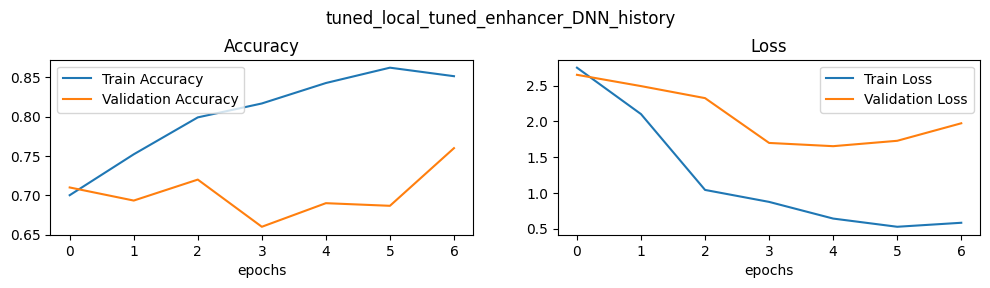

{'Sensitivity': 0.8347107438016529, 'Specificity': 0.7262569832402235, 'AUC': 0.77, 'MCC': 0.5503840228446073}


In [7]:
tuned_local_pretrained_enhancer_DNN_predict_Y = tuned_local_pretrained_enhancer_DNN.predict(tuned_enhancer_local_representations_test)
history_visualize(tuned_local_pretrained_enhancer_DNN_history, "tuned_local_tuned_enhancer_DNN_history")
tuned_performance_local_pretrained_enhancer_DNN = performance(test['label'], tuned_local_pretrained_enhancer_DNN_predict_Y )
print(tuned_performance_local_pretrained_enhancer_DNN)

In [8]:
tuned_global_pretrained_enhancer_DNN = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3, activation='linear'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
tuned_global_pretrained_enhancer_DNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
tuned_global_pretrained_enhancer_DNN_history = tuned_global_pretrained_enhancer_DNN.fit(tuned_global_representations_train, train['label'], 
                                               validation_data=(tuned_global_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

Epoch 1/40
87/87 [==============================] - 1s 6ms/step - loss: 0.4945 - accuracy: 0.7634 - val_loss: 0.5050 - val_accuracy: 0.7667 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - 0s 4ms/step - loss: 0.4752 - accuracy: 0.7782 - val_loss: 0.4694 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - 0s 4ms/step - loss: 0.4705 - accuracy: 0.7681 - val_loss: 0.5151 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 4/40
75/87 [========================>.....] - ETA: 0s - loss: 0.4731 - accuracy: 0.7758
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
87/87 [==============================] - 0s 4ms/step - loss: 0.4751 - accuracy: 0.7775 - val_loss: 0.4926 - val_accuracy: 0.7700 - lr: 0.0010


10/10 [==============================] - 0s 2ms/step


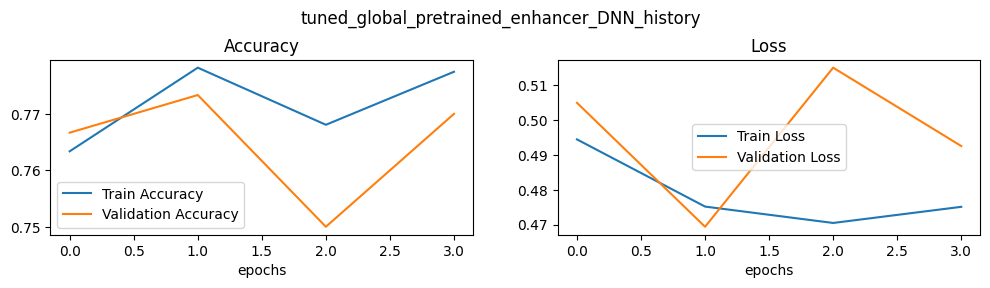

{'Sensitivity': 0.8478260869565217, 'Specificity': 0.7962962962962963, 'AUC': 0.82, 'MCC': 0.6420578831241024}


In [9]:
tuned_global_pretrained_enhancer_DNN_predict_Y = tuned_global_pretrained_enhancer_DNN.predict(tuned_global_representations_test)
history_visualize(tuned_global_pretrained_enhancer_DNN_history, "tuned_global_pretrained_enhancer_DNN_history")
tuned_performance_global_pretrained_enhancer_DNN = performance(test['label'], tuned_global_pretrained_enhancer_DNN_predict_Y )
print(tuned_performance_global_pretrained_enhancer_DNN)

## CNN

In [20]:
tuned_local_pretrained_enhancer_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(202, 1536, 1)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
tuned_local_pretrained_enhancer_CNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
tuned_local_pretrained_enhancer_CNN_history = tuned_local_pretrained_enhancer_CNN.fit(tuned_enhancer_local_representations_train, train['label'], 
                                               validation_data=(tuned_enhancer_local_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

Epoch 1/40
87/87 [==============================] - 267s 3s/step - loss: 0.9222 - accuracy: 0.7222 - val_loss: 0.4999 - val_accuracy: 0.7367 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - 259s 3s/step - loss: 0.4633 - accuracy: 0.7868 - val_loss: 0.4525 - val_accuracy: 0.8100 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - 260s 3s/step - loss: 0.4353 - accuracy: 0.8027 - val_loss: 0.4702 - val_accuracy: 0.7967 - lr: 0.0010
Epoch 4/40
87/87 [==============================] - ETA: 0s - loss: 0.4046 - accuracy: 0.8194
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
87/87 [==============================] - 277s 3s/step - loss: 0.4046 - accuracy: 0.8194 - val_loss: 0.4725 - val_accuracy: 0.8100 - lr: 0.0010


10/10 [==============================] - 5s 450ms/step


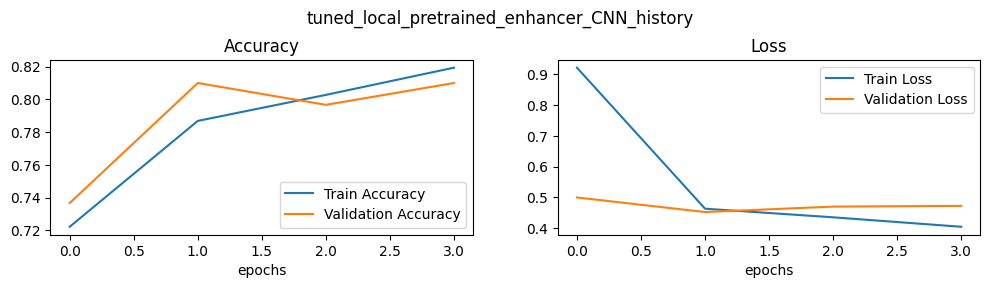

{'Sensitivity': 0.7452229299363057, 'Specificity': 0.7692307692307693, 'AUC': 0.7566666666666667, 'MCC': 0.513893210929176}


In [21]:
tuned_local_pretrained_enhancer_CNN_predict_Y = tuned_local_pretrained_enhancer_CNN.predict(tuned_enhancer_local_representations_test)
history_visualize(tuned_local_pretrained_enhancer_CNN_history, "tuned_local_pretrained_enhancer_CNN_history")
tuned_performance_local_pretrained_enhancer_CNN = performance(test['label'], tuned_local_pretrained_enhancer_CNN_predict_Y )
print(tuned_performance_local_pretrained_enhancer_CNN)

In [24]:
tuned_local_pretrained_enhancer_CNN_predict_Y_valid = tuned_local_pretrained_enhancer_CNN.predict(tuned_enhancer_local_representations_valid)
tuned_performance_local_pretrained_enhancer_CNN_validation = performance(valid['label'], tuned_local_pretrained_enhancer_CNN_predict_Y_valid )
print(tuned_performance_local_pretrained_enhancer_CNN)

10/10 [==============================] - 4s 420ms/step
{'Sensitivity': 0.7452229299363057, 'Specificity': 0.7692307692307693, 'AUC': 0.7566666666666667, 'MCC': 0.513893210929176}


In [22]:
tuned_global_pretrained_enhancer_CNN = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(32, 3, activation='relu', input_shape=(15599, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Flatten(),  
    tf.keras.layers.Dense(64, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')]
)
tuned_global_pretrained_enhancer_CNN.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer='adam',
                  metrics=['accuracy'])
tuned_global_pretrained_enhancer_CNN_history = tuned_global_pretrained_enhancer_CNN.fit(tuned_global_representations_train.reshape(2768, 15599, 1), train['label'], 
                                               validation_data=(tuned_global_representations_valid, valid['label']), 
                                               batch_size=32, epochs=40,
                                               callbacks=training_callbacks)

Epoch 1/40
87/87 [==============================] - 22s 235ms/step - loss: 0.5148 - accuracy: 0.7583 - val_loss: 0.4576 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/40
87/87 [==============================] - 21s 237ms/step - loss: 0.4638 - accuracy: 0.7829 - val_loss: 0.4539 - val_accuracy: 0.8033 - lr: 0.0010
Epoch 3/40
87/87 [==============================] - 22s 248ms/step - loss: 0.4589 - accuracy: 0.7832 - val_loss: 0.4536 - val_accuracy: 0.8167 - lr: 0.0010
Epoch 4/40
87/87 [==============================] - 21s 247ms/step - loss: 0.4566 - accuracy: 0.7807 - val_loss: 0.4532 - val_accuracy: 0.7867 - lr: 0.0010
Epoch 5/40
87/87 [==============================] - 20s 236ms/step - loss: 0.4523 - accuracy: 0.7836 - val_loss: 0.4430 - val_accuracy: 0.8133 - lr: 0.0010
Epoch 6/40
87/87 [==============================] - 21s 236ms/step - loss: 0.4446 - accuracy: 0.7915 - val_loss: 0.4994 - val_accuracy: 0.7733 - lr: 0.0010
Epoch 7/40
87/87 [==============================] - ETA: 0s - lo

10/10 [==============================] - 0s 38ms/step


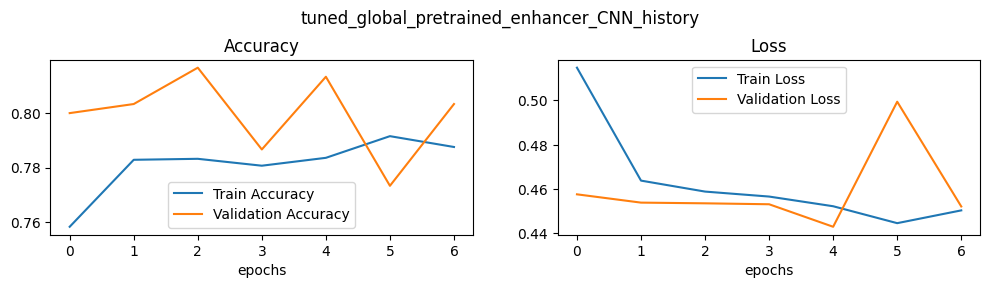

{'Sensitivity': 0.7612903225806451, 'Specificity': 0.7793103448275862, 'AUC': 0.77, 'MCC': 0.5403002502317067}


In [23]:
tuned_global_pretrained_enhancer_CNN_predict_Y = tuned_global_pretrained_enhancer_CNN.predict(tuned_global_representations_test)
history_visualize(tuned_global_pretrained_enhancer_CNN_history, "tuned_global_pretrained_enhancer_CNN_history")
tuned_performance_global_pretrained_enhancer_CNN = performance(test['label'], tuned_global_pretrained_enhancer_CNN_predict_Y )
print(tuned_performance_global_pretrained_enhancer_CNN)